In [34]:
import datetime as dt
from pathlib import Path
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import quandl as ql
pd.set_option('display.float_format', lambda x: '%.9f' % x)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
ql.ApiConfig.api_key = os.getenv("QUANDL_API_KEY")

 # Return Forecasting:  Read Historical Daily Yen Futures Data from Quandl
 In this activity, you will pull historical Dollar-Yen exchange rate futures data from Quandl and test whether there is any predictable behavior using time-series models.

 * First, you'll need to download the futures data using the Quandl API, and return it as a Pandas DataFrame.
 * You'll need a Quandl API key (free): https://www.quandl.com/
 * (Use code "CHRIS/CME_JY1")
 * Trim the resulting data to include only from the the year 1990 through today.

In [14]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

#jpy_futures = ql.get("CHRIS/CME_JY1", start_date="1990-01-01", end_date="2019-09-30")
#jpy_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


In [15]:
#csv = Path("./jpy_futures.csv")
#jpy_futures.to_csv(path_or_buf=csv)

In [35]:
csv = Path("./jpy_futures.csv")
jpy_futures = pd.read_csv(csv, parse_dates=True, infer_datetime_format=True, index_col='Date')
jpy_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

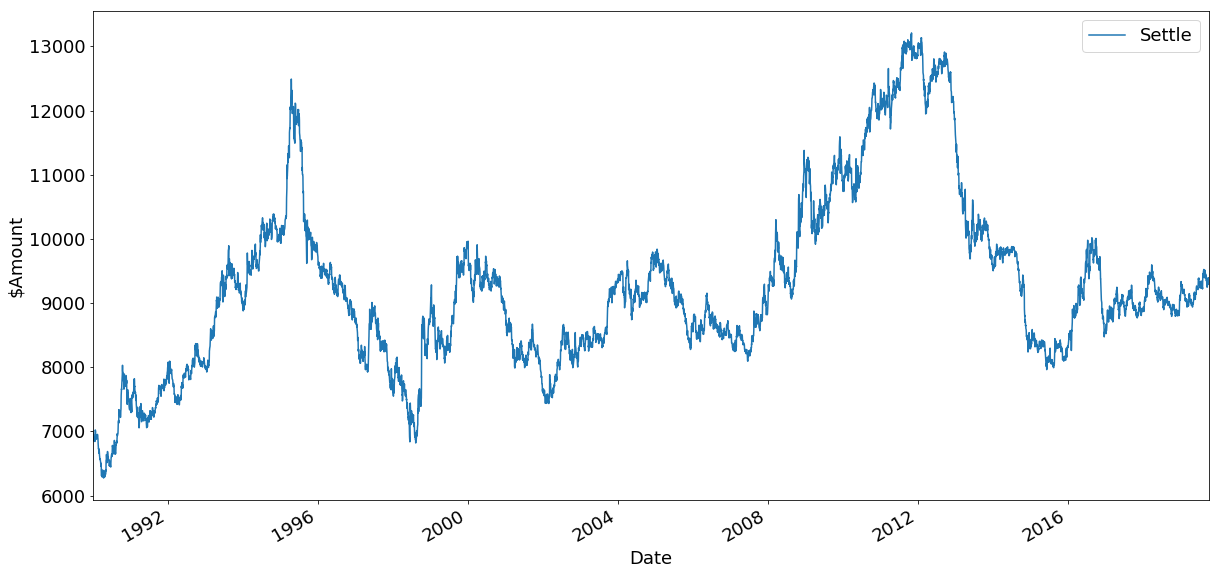

In [17]:
# Plot just the "Settle" column from the dataframe:
plt.rcParams.update({'font.size': 18})
plt.ylabel('$Amount')
jpy_futures["Settle"].plot(figsize=(20,10), label="Settle")
plt.legend(loc='upper right')

 # Return Forecasting: MA/EWMA Smoothing of Futures Prices

 1. Plot the Settle Price, along with a moving average of 15 and 60 days. Use indexing to just plot the data from 2015 onward.
 2. What do you see now, in terms of short versus long-term trends?
 3. Try an exponential moving average, with a half life of 15 days.
 4. Which seems to respond faster, an exponential moving average with a half life of 15 days, or a moving average of 15 days?

 (15 days = 3 weeks)
 (60 days = 3 months)

Text(0, 0.5, '$Amount')

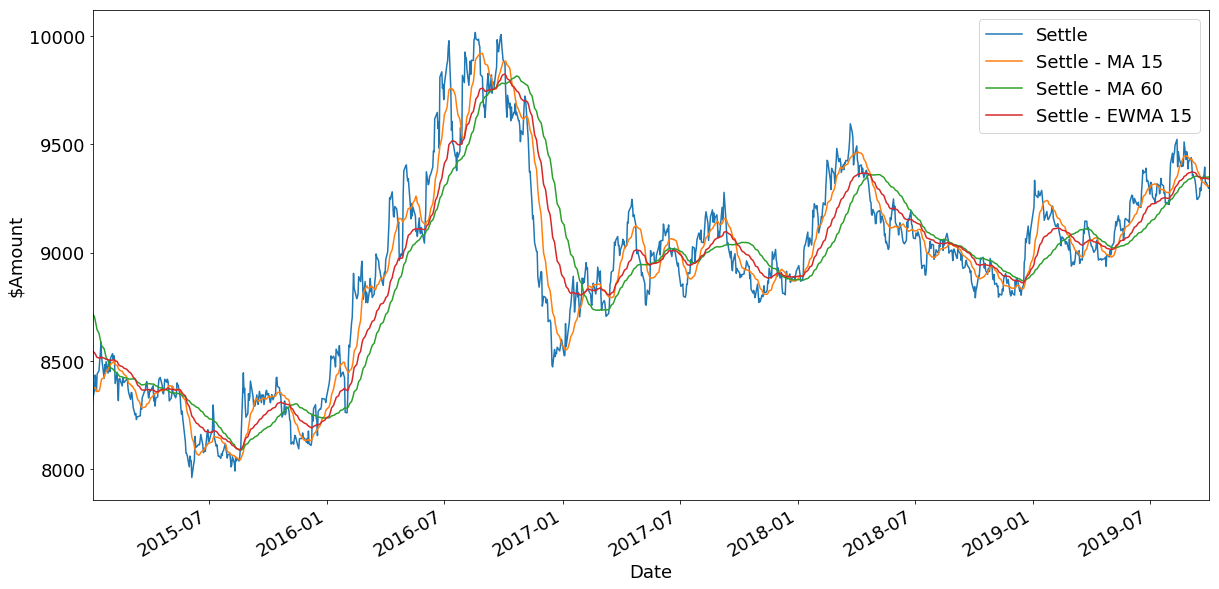

In [18]:
###### Moving averages and exponentially weighted moving averages 
# Create a dataframe using just the "Settle" price
df=jpy_futures[["Settle"]].copy()

# Add in columns for moving average windows of 15 and 60 days, and a column for an EWMA window of 15 days
df["Settle - MA 15"] = df.Settle.rolling(window=15).mean()
df["Settle - MA 60"] = df.Settle.rolling(window=60).mean()
df["Settle - EWMA 15"] =df.Settle.ewm(halflife=15).mean()

# Plot the settle price and moving average/ewma columns all in one plot from 2015:
plt.rcParams.update({'font.size': 18})
df["2015":].plot(figsize=(20,10))
plt.ylabel('$Amount')

# Return Forecasting: Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

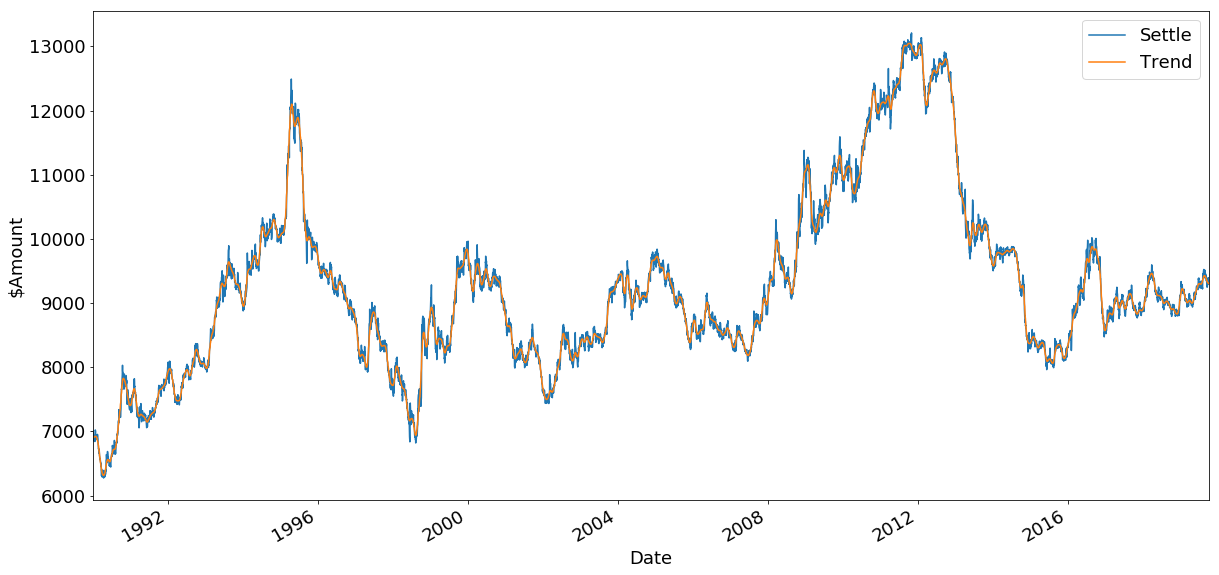

In [19]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend =  sm.tsa.filters.hpfilter(df["Settle"])
# Create a dataframe of just the settle price, and add in the "noise" and "trend" series from above:
futures_decomp =  jpy_futures[["Settle"]].copy()
futures_decomp["Noise"] =  ts_noise 
futures_decomp["Trend"] =  ts_trend 

# Plot the "Settle" and "Trend" price 
futures_decomp["Settle"].plot(figsize=(20,10), label="Settle")
futures_decomp["Trend"].plot(figsize=(20,10), label="Trend")
plt.ylabel('$Amount')
plt.legend(loc='upper right')

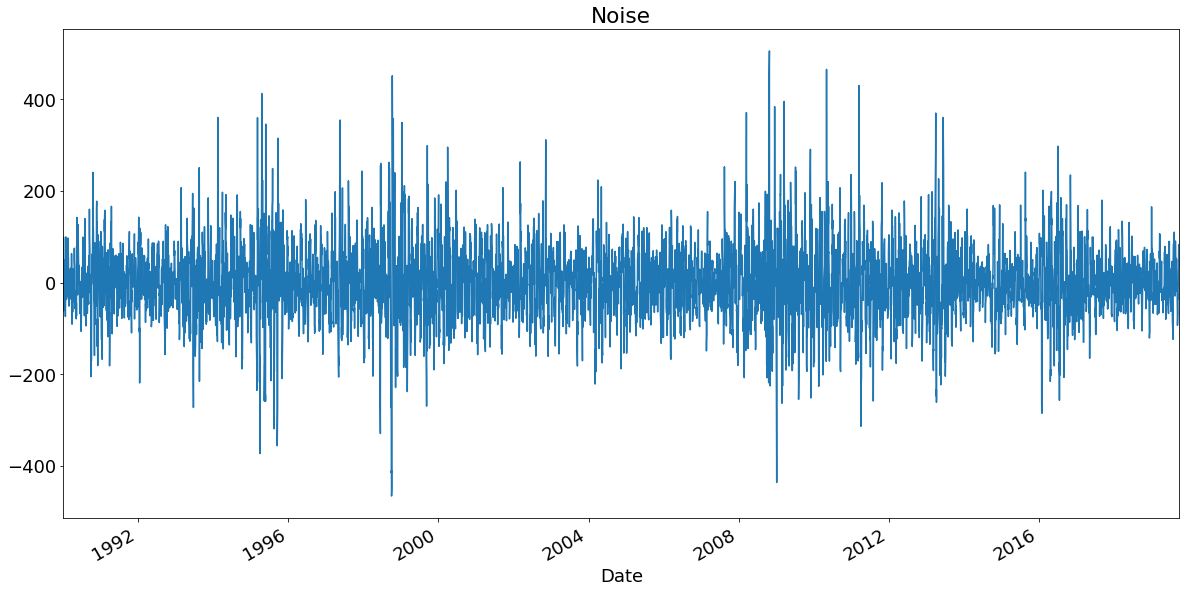

In [20]:
# Then plot the "noise" separately
futures_decomp["Noise"].plot(figsize=(20,10), title="Noise")

 # Return Forecasting: Seasonal Effects with Sklearn Linear Regression
 Using the full dataset, use a SKLearn linear regression to predict Yen futures ("settle") returns with *lagged* Yen futures returns and categorical calendar seasonal effects (e.g., day-of-week or week-of-year seasonal effects).


In [34]:
#Use the dataframe containing "Settle" Prices:
jpy_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


In [21]:
from sklearn.linear_model import LinearRegression

# Construct a "Futures Return" column, using pandas pct_change() on the "Settle" price 
# It will be easier to also multiply this by 100, both to read and when we use it with SKLearn:
jpy_futures["Futures Return"] = jpy_futures["Settle"].copy().pct_change()*100

# Feature Engineering
# Create a second "Lagged Return" variable, that is the futures return variable shifted above, but lagged 1 day:
# We"ll use this lagged return as the feature vector X:
jpy_futures["Lagged Return"] = jpy_futures["Futures Return"].shift()
jpy_futures = jpy_futures.replace(-np.inf, np.nan).dropna()

# Construct a new "X" dataframe using just the "Lagged Return" variable:
X = jpy_futures["Lagged Return"].to_frame()

In [22]:
# Add into the X dataframe either a "dayofweek" or "weekofyear" column, (e.g., using X.index.weekofyear) 
X["Week_of_Year"] = X.index.weekofyear

# Create a new categorical X dataframe, by using pd.get_dummies() on the seasonal column created just above:
X_binary_encoded = pd.get_dummies(X, columns=['Week_of_Year'], drop_first=True)
X_binary_encoded = X_binary_encoded.drop("Lagged Return", axis=1)
X_binary_encoded.head()

,Week_of_Year_2,Week_of_Year_3,Week_of_Year_4,Week_of_Year_5,Week_of_Year_6,Week_of_Year_7,Week_of_Year_8,Week_of_Year_9,Week_of_Year_10,Week_of_Year_11,...,Week_of_Year_44,Week_of_Year_45,Week_of_Year_46,Week_of_Year_47,Week_of_Year_48,Week_of_Year_49,Week_of_Year_50,Week_of_Year_51,Week_of_Year_52,Week_of_Year_53
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-18,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-19,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-20,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Create a "y" series, using just the "Futures Return" column created above.
y = jpy_futures["Futures Return"].copy()

# Construct a "LinearRegression" object:
model = LinearRegression()

# Fit a model using the X and y objects:
results = model.fit(X_binary_encoded, y)

In [24]:
# Construct predictions based on the X object:
predictions = model.predict(X_binary_encoded)
predictions

array([-0.07469888, -0.07469888, -0.07469888, ..., -0.10745814,
       -0.10745814, -0.08255223])

 Summarize the quality of your model using R2 and root-mean-squared-error (RMSE) statistics. How good is it?

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)

# Calculate mean squared error 
# (A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.)
mse = mean_squared_error(y, predictions)

# Using mean squared eror above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {y.std()}")

Mean Squared Error (MSE): 0.28457039113900323
R-squared (R2 ): 0.04782521327990796
Root Mean Squared Error (RMSE): 0.5334513952920202
Standard Deviation of Futures Return: 0.5468789851680016


 #### Plotting and Independent (X) Variable Interpretation

 Plot the model predictions of returns against actual returns, for just data from 2018 onward.

In [26]:
# Create a "y" dataframe, using just the "Futures Return" column created above. 
y_df = y.to_frame()

# Add the model predictions from above as an additional column to that dataframe:
y_df["Prediction"] = predictions 
y_df.head()

,Futures Return,Prediction
Date,,
2014-02-18,-0.427829276,-0.074698879
2014-02-19,-0.020460358,-0.074698879
2014-02-20,0.020464545,-0.074698879
2014-02-21,-0.204603581,-0.074698879
2014-02-24,0.020502307,-0.071300937


Text(0, 0.5, '%Return')

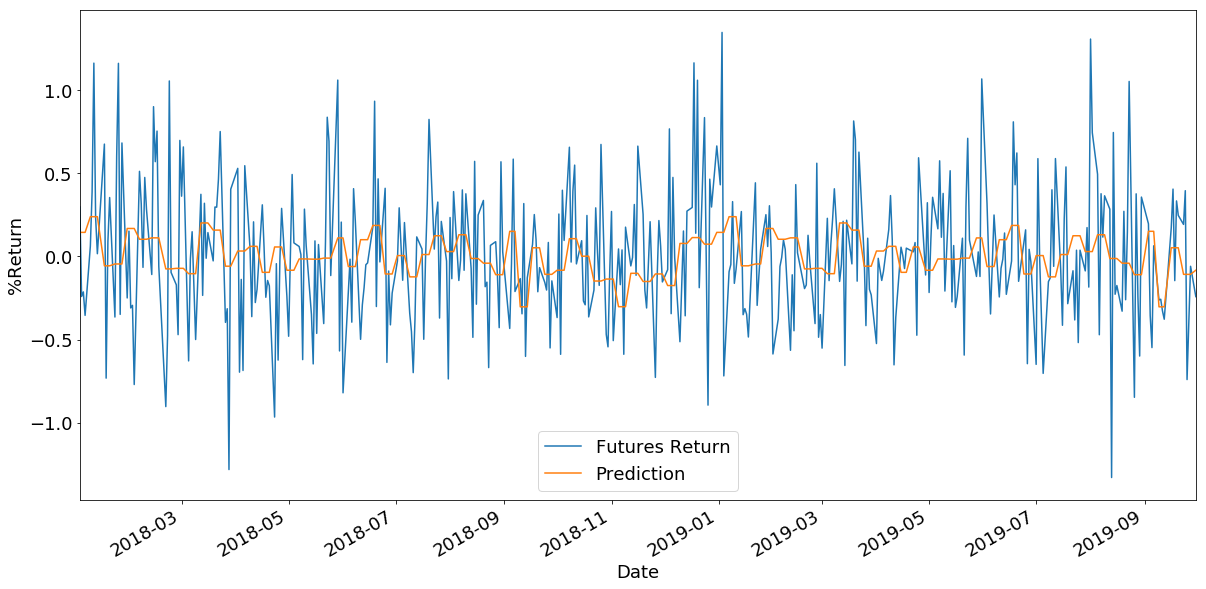

In [27]:
# Plot the two from 2018 onward
y_df["2018":"2019"].plot(figsize=(20,10))
plt.ylabel('%Return')

 Separately, plot the calendar effects estimated from the model using matplotlib. Do you see any seasonal patterns?

In [28]:
# Construct a dataframe of the model calendar-effect coefficients and review the output:
results = pd.DataFrame(model.coef_, columns=["Coefficient"], index=X_binary_encoded.columns)

# Filter results so that it only includes either the day-of-week or week-of-year effect 
results = (results[results.index.str.contains("Week_of_Year")])

results.head(10)

,Coefficient
Week_of_Year_2,0.094240266
Week_of_Year_3,-0.201012415
Week_of_Year_4,-0.189889082
Week_of_Year_5,0.023445567
Week_of_Year_6,-0.041351321
Week_of_Year_7,-0.032924361
Week_of_Year_8,-0.219508090
Week_of_Year_9,-0.216110147
Week_of_Year_10,-0.248240161
Week_of_Year_11,0.056598863


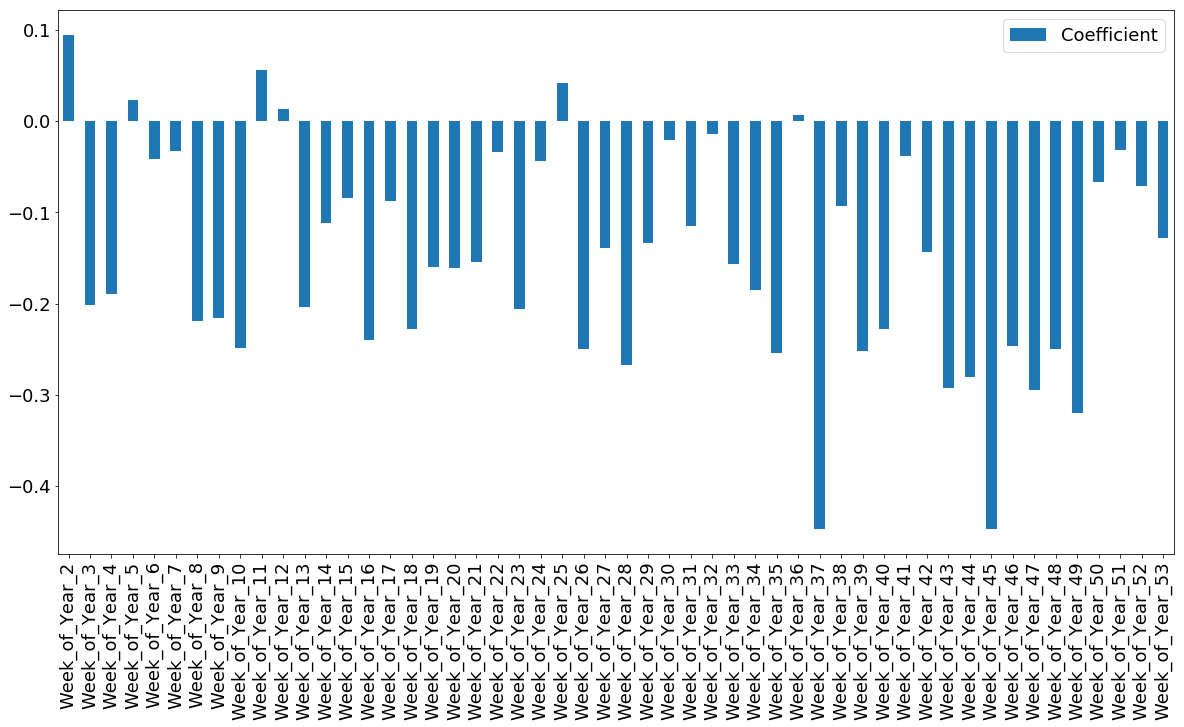

In [29]:
# Plot the results of the individual seasonal effects using pandas df.plot()
results.plot(kind="bar",figsize=(20,10))

 # Return Forecasting: Autocorrelation and the ARMA Model

 Using futures Settle *Returns*, estimate an ARMA model.
 1. Set the AR and MA ("p" and "q") parameters to p=2 and q=1.
 2. Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30. If, when looking at the correlation graphs, additional lags seem important for predicting returns, increase the number of lags in the ARMA model from (1).
 3. Does increasing the number of "p" or "q" increase the ability of the model? Compare your results between the two models by comparing the Bayseian Information Criterion, or BIC.

In [30]:
from statsmodels.tsa.arima_model import ARMA
# Create a series using "Settle" price percentage returns, and drop any nan's:
settle_df = jpy_futures[["Settle"]].pct_change().dropna()

# Estimate and ARMA model using statsmodels
# Hint: ARMA(df, order=(p, q)).fit()
p = 2
q = 1
model = ARMA(settle_df.values, order=(p,q))
arma_results = model.fit()

In [31]:
# Output model summary results:
arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1403
Model:                     ARMA(2, 1)   Log Likelihood                5318.878
Method:                       css-mle   S.D. of innovations              0.005
Date:                Wed, 09 Oct 2019   AIC                         -10627.755
Time:                        21:14:26   BIC                         -10601.523
Sample:                             0   HQIC                        -10617.950
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.096e-05      0.000     -0.137      0.891      -0.000       0.000
ar.L1.y        0.3082      0.335      0.921      0.357      -0.348       0.964
ar.L2.y        0.0469      0.027      1.759      0.079      -0.005       0.099
ma.L1.y       -0.3221      0.334     -0.964      0.335      -0.977       0.333
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3817           +0.0000j            2.3817            0.0000
AR.2           -8.9552           +0.0000j            8.9552            0.5000
MA.1            3.1048           +0.0000j            3.1048            0.0000
-----------------------------------------------------------------------------
"""

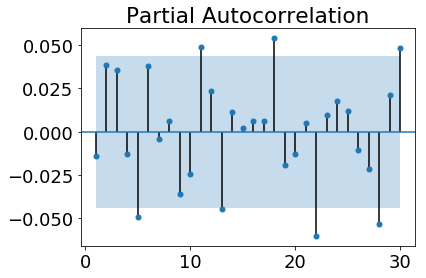

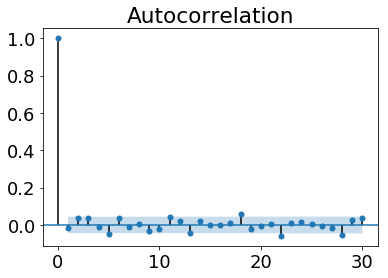

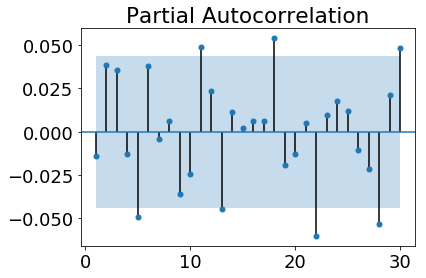

In [32]:
# Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation (For detecting # of MA ("P") Lags)
plot_acf(settle_df.Settle, lags=30, alpha=0.1) 

# Partial Autocorrelation (For detecting # of MA ("P") Lags)
plot_pacf(settle_df.Settle, lags=30, zero=False, alpha=0.1)

In [33]:
p = 17
q = 6

# Esimate your model based on your interpretation of the autocorrelation/partial autocorrelation plots:
model = ARMA(settle_df.values, order=(p,q))

arma_results = model.fit()

arma_results.summary()

C:\Users\minak\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\minak\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1403
Model:                    ARMA(17, 6)   Log Likelihood                5332.577
Method:                       css-mle   S.D. of innovations              0.005
Date:                Wed, 09 Oct 2019   AIC                         -10615.154
Time:                        21:26:12   BIC                         -10483.995
Sample:                             0   HQIC                        -10566.129
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.175e-05      0.000     -0.143      0.886      -0.000       0.000
ar.L1.y        0.0358      0.598      0.060      0.952      -1.136       1.208
ar.L2.y        0.1407      0.450      0.313      0.755      -0.741       1.022
ar.L3.y       -0.0888      0.187     -0.475      0.635      -0.455       0.277
ar.L4.y       -0.3995      0.299     -1.336      0.182      -0.986       0.187
ar.L5.y       -0.4423      0.340     -1.301      0.193      -1.109       0.224
ar.L6.y        0.5774      0.493      1.172      0.241      -0.388       1.543
ar.L7.y        0.0397      0.051      0.783      0.434      -0.060       0.139
ar.L8.y       -0.0215      0.054     -0.397      0.692      -0.128       0.085
ar.L9.y       -0.0807      0.042     -1.924      0.055      -0.163       0.002
ar.L10.y      -0.0153      0.053     -0.290      0.772      -0.119       0.088
ar.L11.y       0.0992      0.050      1.988      0.047       0.001       0.197
ar.L12.y       0.0023      0.054      0.042      0.967      -0.104       0.108
ar.L13.y      -0.0670      0.037     -1.832      0.067      -0.139       0.005
ar.L14.y      -0.0282      0.068     -0.417      0.677      -0.161       0.104
ar.L15.y       0.0534      0.060      0.896      0.370      -0.063       0.170
ar.L16.y       0.0306      0.044      0.691      0.490      -0.056       0.117
ar.L17.y      -0.0027      0.052     -0.052      0.958      -0.104       0.098
ma.L1.y       -0.0494      0.596     -0.083      0.934      -1.218       1.119
ma.L2.y       -0.0924      0.444     -0.208      0.835      -0.963       0.778
ma.L3.y        0.1250      0.192      0.650      0.516      -0.252       0.502
ma.L4.y        0.3782      0.313      1.209      0.227      -0.235       0.991
ma.L5.y        0.3919      0.354      1.106      0.269      -0.303       1.086
ma.L6.y       -0.5217      0.469     -1.113      0.266      -1.441       0.397
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.7023           -0.7669j            1.0399           -0.1320
AR.2             0.7023           +0.7669j            1.0399            0.1320
AR.3             1.2441           -0.0000j            1.2441           -0.0000
AR.4             1.1675           -0.5035j            1.2714           -0.0648
AR.5             1.1675           +0.5035j            1.2714            0.0648
AR.6             0.6217           -1.0321j            1.2049           -0.1637
AR.7             0.6217           +1.0321j            1.2049            0.1637
AR.8            -0.2116           -1.2308j            1.2489           -0.2771
AR.9            -0.2116           +1.2308j            1.2489            0.2771
AR.10           -0.5363           -0.8907j            1.0397           -0.3363
AR

 # Return Forecasting: Deploying the ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

 2. Plot the residuals from the model. If residuals are the part of returns that our model *doesn"t* explain, does it seem like our model has missed any seasonality?
 3. Construct a 15 day (3 week) forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [37]:
# For ARIMA, construct a dataframe using just the futures "Settle" prices:
df = jpy_futures['Settle'].to_frame()
df.head()

,Settle
Date,
1990-01-02,6847.000000000
1990-01-03,6887.000000000
1990-01-04,7008.000000000
1990-01-05,6950.000000000
1990-01-08,6959.000000000


In [38]:
from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df, order=(5,1,1))
model_fit = model.fit() 
# Output model summary results:
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:               D.Settle   No. Observations:                 7503
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41887.150
Method:                       css-mle   S.D. of innovations             64.314
Date:                Wed, 09 Oct 2019   AIC                          83790.301
Time:                        23:09:25   BIC                          83845.685
Sample:                             1   HQIC                         83809.319
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3263      0.701      0.466      0.642      -1.047       1.700
ar.L1.D.Settle     0.2828      0.711      0.398      0.691      -1.110       1.676
ar.L2.D.Settle     0.0006      0.016

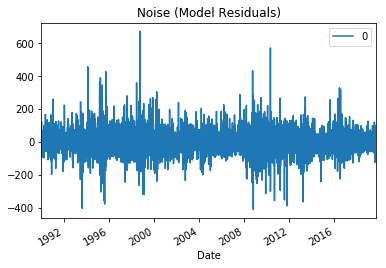

In [47]:
# plot residual errors:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Noise (Model Residuals)")

In [48]:
print(residuals.describe())

                   0
count 7503.000000000
mean     0.000775688
std     64.318572831
min   -410.302187889
25%    -34.361941337
50%     -1.047978389
75%     32.417894248
max    669.256891097


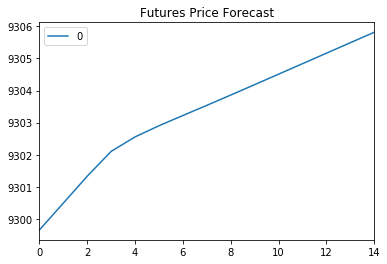

In [40]:
# Construct a 15 day (3 week) forecast for the Settle Price. 
# What does the model forecast will happen to the Japanese Yen in the near term?
# Specifically, construct a pandas DataFrame containing ARIMA model forecasts for a 15-day window:
pd.DataFrame(model_fit.forecast(steps=15)[0]).plot(title="Futures Price Forecast")

 # Volatility Forecasting

 Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

### Volatility Forecasting: GARCH and EGARCH Models
Using the "arch" package, estimate either GARCH(1,1) or an EGARCH(p,q) volatility forecast model on futures settle returns.

In [49]:
import arch as arch

ModuleNotFoundError: No module named 'arch'

In [33]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by *100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=(fut[["Settle"]].pct_change()*100)
returns=returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-06-28,-0.032140561
2019-07-01,-0.648376380
2019-07-02,0.587886306
2019-07-03,-0.010723861
2019-07-05,-0.702488202


In [28]:
# Estimate a GARCH(1,1) model using the "arch" package:
# (We need to drop all NaN"s first in order to get this to run):
am = # YOUR CODE HERE 
res = am.fit(# YOUR CODE HERE)

                           AR - GARCH Model Results                           
Dep. Variable:                 Settle   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1025.22
Distribution:                  Normal   AIC:                           2062.44
Method:            Maximum Likelihood   BIC:                           2093.66
                                        No. Observations:                 1343
Date:                Sun, Jul 07 2019   Df Residuals:                     1337
Time:                        22:06:40   Df Model:                            6
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -4.5850e-03  1.273e-02     -0.360      0.

In [29]:
# Output the summary results of the GARCH model:
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                 Settle   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1025.22
Distribution:                  Normal   AIC:                           2062.44
Method:            Maximum Likelihood   BIC:                           2093.66
                                        No. Observations:                 1343
Date:                Sun, Jul 07 2019   Df Residuals:                     1337
Time:                        22:06:40   Df Model:                            6
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -4.5850e-03  1.273e-02     -0.360      0.

### Volatility Forecasting: Identifying Patterns of Clustered Volatility

GARCH/EGARCH, etc. models are good for capturing the "volatility clustering" effect that is common in financial data. After estimating your model, can you identify periods when volatility clusters together?

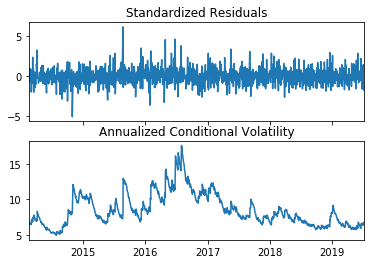

In [30]:
# Plot the model"s conditional volatility for the Yen:
# Hint: use .plot(annualize="D")
fig = # YOUR CODE HERE 

### Volatility Forecasting: 3-day Yen Volatility Forecasts using GARCH/EGARCH
  * Let's do some forecasting of near-term risk. Specifically, use the .forecast() method to calculate 3-day forecasts. Then plot the resulting 3-day annualized variance. Is Yen volatility expected to rise or fall in the near term?

In [35]:
# Note--You can either specify today"s date manually, or use pd.datetime.today().strftime("%Y-%m-%d") 
# (example format: start="2019-06-28")
# If you have problems with datetime, 
# specify data date manually using the most recent trading date in the dataframe
todays_date = pd.datetime.today().strftime("%Y-%m-%d")                  
# todays_date = '2019-07-05'
# Forecast volatility, from today"s date until the following three days:
forecast_horizon = # YOUR CODE HERE 
forecasts = # YOUR CODE HERE 
forecasts

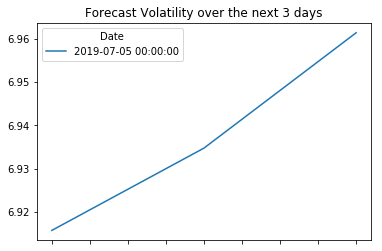

In [36]:
# Plot the annualized volatility forecast using pd.plot():
# (Make sure to use dropna() on the forecasts before plotting):
# (There are 252 trading days in a year)
# Note: each column in forecasts.variance represents one day ahead: 
plot_title = f"Forecast Volatility over the next {forecast_horizon} days"
model_forecasts = # YOUR CODE HERE 
model_forecasts.dropna().T.plot(title=plot_title) 

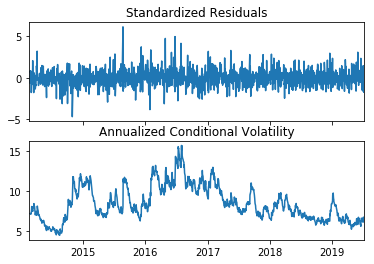

In [38]:
fig = # YOUR CODE HERE 

 # Out-of-Sample Predictions
 So far, you"ve used the full dataset to construct a model. Let's try a more rigorous technique.

### Out-of-Sample Predictions: Slicing the Data into Training and Test Set ("One Shot" Approach)

Using the SKLearn regression model and just lagged returns as the independent variable, start by estimating a model using **training data** from January, 2015 through December 2017.

In [75]:
# If you haven"t already, create and add "Futures Return" and "Lagged Futures Return" variables to your dataframe:
# Replace inf, -inf with np.nan, then drop any row with at least one np.nan in the dataframe
fut["Futures Return"] = # YOUR CODE HERE 
fut["Lagged Return"] = # YOUR CODE HERE 
fut = fut.replace(-np.inf, np.nan).dropna()
fut[["Futures Return", "Lagged Return"]].head()

,Futures Return,Lagged Return
Date,,
2014-03-04,-0.801298306,0.346055980
2014-03-06,-0.766871166,-0.801298306
2014-03-07,-0.247295209,-0.766871166
2014-03-10,0.103295114,-0.247295209
2014-03-11,0.278609019,0.103295114


In [76]:
# Using datetime index slicing, create a "training" data dataframe using data from just 2015-01-01 to 2017-12-31
train = # YOUR CODE HERE 
print("Training set covers from ", train.index.min(), " to ", train.index.max())
train.head(2)

Training set covers from  2015-01-02 00:00:00  to  2017-12-29 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2015-01-02,8352.000000000,8353.000000000,8286.000000000,8310.000000000,34.000000000,8315.000000000,101438.000000000,222022.000000000,-0.407234399,-0.262812089
2015-01-05,8305.000000000,8382.000000000,8293.000000000,8371.000000000,56.000000000,8371.000000000,165487.000000000,226085.000000000,0.673481660,-0.407234399


In [77]:
# Using datetime index slicing, create a "test" data dataframe using data from 2018-01-01 through the end of the data
test = # YOUR CODE HERE 
print("Test set covers from ", test.index.min(), " to ", test.index.max())
test.head(2)

Test set covers from  2018-01-02 00:00:00  to  2019-07-05 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2018-01-02,8909.500000000,8957.500000000,8898.500000000,8938.000000000,26.500000000,8940.500000000,96714.000000000,227884.000000000,0.297285169,0.224870699
2018-01-03,8943.000000000,8947.500000000,8913.000000000,8921.000000000,21.500000000,8919.000000000,93498.000000000,226582.000000000,-0.240478720,0.297285169


  * Then use the model developed on a test set using data from 2018 onward.

In [78]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = # YOUR CODE HERE 
y_train = # YOUR CODE HERE 
X_test = # YOUR CODE HERE 
y_test = # YOUR CODE HERE 

In [79]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
# YOUR CODE HERE 

# Score how that model works using only the test data
# YOUR CODE HERE 

# And make a prediction of "y" values for just the test dataset
predictions = # YOUR CODE HERE 

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [80]:
Results.head()

,Futures Return,Predicted Return
Date,,
2018-01-02,0.297285169,0.004644804
2018-01-03,-0.240478720,0.002612746
2018-01-04,-0.213028366,0.017703208
2018-01-05,-0.353932584,0.016932910
2018-01-08,0.062017252,0.020886894



  * Compare the RMSE from the model using the test sample to the RMSE when using the full-sample. Are the results surprising?

In [81]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = # YOUR CODE HERE 

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
one_shot_rmse = # YOUR CODE HERE 
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {one_shot_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.40994570155874877


In [82]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = # YOUR CODE HERE 

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = # YOUR CODE HERE 

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = # YOUR CODE HERE 
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.6257993297323167


### Out-of-Sample Predictions: The Rolling Out-of-Sample Approach

Let's take the model above (i.e., SKLearn predicting futures returns with lagged futures returns), but apply it using a rolling, out of sample approach. This method, which is specific to time-series predictions, will be a more realistic and more rigorous approximation of how the model would perform in real life.

Specifically, start at the beginning of the dataset and "roll forward" one week at a time, using a 26-week (6 month) rolling training window.

In [83]:
# Main Idea: Each week, re-estimate the model, then trade on it the following week. 
# Continue this "out of sample" approach throughout the dataset.

In [84]:
# Construct an empty placeholder dataframe, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
# Construct an empty placeholder dataframe, with a column named "Actual Returns"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_actuals = pd.DataFrame(columns=["Actual Returns"])

# construct a list of all pandas weekly periods that are in the dataset:
weeks = fut.index.to_period("w").unique()

# Specify a training window (26 weeks (6 months) of data)
training_window = 26  

# Write a for loop that iterates from 0 to the number of weeks (minus the training window) in the dataset:
# We have to subtract the length of the training window because
# Going beyond this goes beyond the length of our dataset    
for i in range(0, (len(weeks) - training_window - 1)):
# Create an datetime object to mark the beginning of the training window (which changes, for each "i"):     
    beginning_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    start_training_period = # YOUR CODE HERE 
# Create an datetime object to mark the ending of the training window (which would be "i"+training_window_length):  
    ending_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    end_training_period = # YOUR CODE HERE 
# Create a datetime object that marks the week of test-window data:
    test_week = # YOUR CODE HERE 
# Create a string variable from the beginning of that time object with format="%Y-%m-%d"
    start_test_week = # YOUR CODE HERE 
# Create a string variable from the end of that time object with format="%Y-%m-%d"    
    end_test_week = # YOUR CODE HERE 
# Create a dataframe that includes only data during the training window
# (Use datetime slicing and the two start and end string dates constructed above):
    train =  # YOUR CODE HERE 
# Do the same to construct a dataframe including data in the test sample window:    
    test =  # YOUR CODE HERE 
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
    X_train = train["Lagged Return"].to_frame()
    y_train = train["Futures Return"]
    X_test = test["Lagged Return"].to_frame()
    y_test = test["Futures Return"]
# Fit a linear regression to the two training dataframes
    # YOUR CODE HERE 
# Use the model to construct predictions on the X test dataframe,
# and save them as a temporary pandas DataFrame 
    predictions =  # YOUR CODE HERE 
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
# Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
# Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    # Once the loop is done, concatenate (combine) the two dataframes to a final "Results" dataframe:    
    Results =  # YOUR CODE HERE 


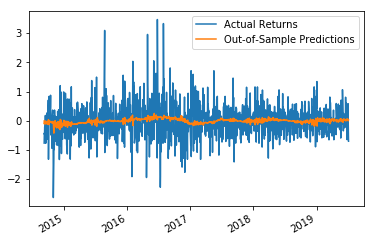

In [85]:
# Plot the results:
# YOUR CODE HERE 

  * Evaluate the model RMSE.
      * Which has the better RMSE--this more robust method, or the single ("one-shot") training and test split just above?

In [86]:
# Calculate the mean_squared_error on the Results DataFrame:
# (This compares the average (squared) difference between actual and model-predicted returns)
rolling_mse = # YOUR CODE HERE 
# Then use that to calculate the Root-Mean-Squared Error (RMSE):
rolling_rmse = # YOUR CODE HERE 
rolling_rmse

0.5738123732985758

In [87]:
# Compare the RMSE from the training-testing single split versus the rolling out-of-sample approach we just did:
# YOUR CODE HERE 

0.40994570155874877

Challenge: Can you calculate the out-of-sample R2? Based on this, should we bet money on this model?

In [89]:
# YOUR CODE HERE 

Out-of-Sample R-squared: -0.022563606609533604
